<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3 Web APIs and NLP

_Authors: Joel Quek (SG)_

# Problem Statement

NLP Model to match posts from r/investing, r/stockmarket, r/wallstreetbets

[Reddit Post Classification](https://towardsdatascience.com/reddit-post-classification-b70258d6affe)

[Text Cleaning for NLP: A Tutorial](https://monkeylearn.com/blog/text-cleaning/) [Important]

# Exploratory Data Analysis

## Import Libraries

In [54]:
#All libraries used in this project are listed here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

import re
from bs4 import BeautifulSoup 

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score, make_scorer, recall_score, precision_score,accuracy_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier



# Open Scraped Datasets

The jupytyer notebooks for scraping are 'reddit-scrape.ipynb' and 'wallstreetbets-scrape.ipynb'

In [2]:
investing_df = pd.read_csv('datasets/investing.csv')
stockmarket_df = pd.read_csv('datasets/stockmarket.csv')

## r/investing

In [3]:
investing_df.shape

(7995, 75)

In [4]:
investing_df.iloc[investing_df.shape[0]-1]['created_utc']

# GMT: Friday, July 8, 2022 9:18:46 AM

1657271926

In [5]:
investing_df=investing_df[['subreddit', 'author', 'selftext', 'title']]
investing_df.head()

,subreddit,author,selftext,title
0,investing,HomeInvading,"Hey guys, I’m a 22 year old male, I grew up wi...",Help a young man out would ya?
1,investing,ocean-airseashell10,[removed],Treasury bonds is it a good idea to buy
2,investing,ocean-airseashell10,[removed],How to buy treasury bonds? Is treasury’s direc...
3,investing,iamjokingiamserious,[removed],Early Exercise of Stock Options
4,investing,jamesterryburke01,Hello Redditors 👋 \n\nI work as a Investment C...,Alternative Investments -


## r/stockmarket

In [6]:
stockmarket_df.shape

(7494, 81)

In [7]:
stockmarket_df.iloc[stockmarket_df.shape[0]-1]['created_utc']

# GMT: Wednesday, July 13, 2022 2:13:58 AM

1657678438

In [8]:
stockmarket_df=stockmarket_df[['subreddit', 'author', 'selftext', 'title']]
stockmarket_df.head()

,subreddit,author,selftext,title
0,StockMarket,zitrored,NaN,Looking for the next exogenous event that take...
1,StockMarket,CompetitiveMission1,[Link to the full article (4 min read)](https:...,China stocks notch trillion-dollar gain on hop...
2,StockMarket,jaltrading21,NaN,Get ready for some economic news and company e...
3,StockMarket,ShabbyShamble,NaN,Market Recap! Bear Market Blues! Palantir (PLT...
4,StockMarket,PriceActionHelp,NaN,Why it's not smart to rely on the RSI divergence


# Final Cleaning 

## Handling Missing Values

In [9]:
investing_df['selftext']=investing_df['selftext'].fillna('')
stockmarket_df['selftext']=stockmarket_df['selftext'].fillna('')


In [10]:
investing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7995 entries, 0 to 7994
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  7995 non-null   object
 1   author     7995 non-null   object
 2   selftext   7995 non-null   object
 3   title      7995 non-null   object
dtypes: object(4)
memory usage: 250.0+ KB


In [11]:
stockmarket_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7494 entries, 0 to 7493
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  7494 non-null   object
 1   author     7494 non-null   object
 2   selftext   7494 non-null   object
 3   title      7494 non-null   object
dtypes: object(4)
memory usage: 234.3+ KB


## Feature Engineering

I will combine the text from columns 'author','selftext' and 'title'

In [12]:
#investing_df['Posts']='Author: '+investing_df['author']+' Title: ' + investing_df['title']+' Text: '+investing_df['selftext']
#stockmarket_df['Posts']='Author: '+stockmarket_df['author']+' Title: ' + stockmarket_df['title']+' Text: '+stockmarket_df['selftext']


In [13]:
investing_df['Posts']=investing_df['author']+ ' '+investing_df['title']+' '+investing_df['selftext']
stockmarket_df['Posts']=stockmarket_df['author']+ ' '+stockmarket_df['title']+' '+stockmarket_df['selftext']

In [14]:
investing_df=investing_df[['subreddit','Posts']]
stockmarket_df=stockmarket_df[['subreddit','Posts']]


In [15]:
investing_df.head(3)

,subreddit,Posts
0,investing,HomeInvading Help a young man out would ya? He...
1,investing,ocean-airseashell10 Treasury bonds is it a goo...
2,investing,ocean-airseashell10 How to buy treasury bonds?...


In [16]:
stockmarket_df.head(3)

,subreddit,Posts
0,StockMarket,zitrored Looking for the next exogenous event ...
1,StockMarket,CompetitiveMission1 China stocks notch trillio...
2,StockMarket,jaltrading21 Get ready for some economic news ...


## Concatenate both Dataframes

In [17]:
df = pd.concat([investing_df,stockmarket_df],ignore_index=True)

In [18]:
df.shape

(15489, 2)

In [19]:
df['subreddit'].value_counts()

investing      7995
StockMarket    7494
Name: subreddit, dtype: int64

In [20]:
df.head()

,subreddit,Posts
0,investing,HomeInvading Help a young man out would ya? He...
1,investing,ocean-airseashell10 Treasury bonds is it a goo...
2,investing,ocean-airseashell10 How to buy treasury bonds?...
3,investing,iamjokingiamserious Early Exercise of Stock Op...
4,investing,jamesterryburke01 Alternative Investments - He...


## Lowercase

In [21]:
df['Posts']=[c.lower() for c in df['Posts']]

## Remove Non Letters

In [22]:
df['Posts']=df['Posts'].map(lambda x: re.sub("[^a-zA-Z]", " ", x)) 

## Remove Stop Words

In [23]:
def remove_stop_words(text):
    stops = stopwords.words('english')
    stops=set(stops)
    text = " ".join([word for word in text.split() if word not in (stops)])
    # text = [w for w in text if not w in stops]

    return text

In [24]:
df['Posts']=df['Posts'].map(lambda x: remove_stop_words(x))

## Hot Encode Target Vector

In [25]:
df['subreddit']=df['subreddit'].map({'investing': 0, 'StockMarket': 1})

In [26]:
df.head()

,subreddit,Posts
0,0,homeinvading help young man would ya hey guys ...
1,0,ocean airseashell treasury bonds good idea buy...
2,0,ocean airseashell buy treasury bonds treasury ...
3,0,iamjokingiamserious early exercise stock optio...
4,0,jamesterryburke alternative investments hello ...


In [27]:
X=df['Posts']
y=df['subreddit']

In [28]:
y.value_counts(normalize = True)

0    0.516173
1    0.483827
Name: subreddit, dtype: float64

In [29]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y, # stratify means the proportion of 0s and 1s are kept
                                                    random_state=42)

----

# Count Vectorizer

In [30]:
# Instantiate a CountVectorizer with the default hyperparameters.
cvec = CountVectorizer()

In [31]:
# Fit the vectorizer on our corpus.
cvec.fit(X_train)

CountVectorizer()

In [32]:
# Transform the corpus.
X_train = cvec.transform(X_train) 
# transform creates the vector of words

In [33]:
X_train.shape

(10377, 29062)

In [34]:
print(X_train)

  (0, 492)	1
  (0, 1333)	1
  (0, 5180)	1
  (0, 10765)	1
  (0, 13654)	1
  (0, 14529)	1
  (0, 16149)	1
  (0, 16984)	1
  (0, 25442)	1
  (0, 25662)	1
  (1, 286)	1
  (1, 3116)	1
  (1, 3428)	1
  (1, 12578)	1
  (1, 20803)	1
  (1, 21060)	1
  (2, 358)	1
  (2, 3506)	1
  (2, 3521)	1
  (2, 4505)	1
  (2, 4593)	1
  (2, 6099)	2
  (2, 7480)	1
  (2, 8155)	1
  (2, 8625)	1
  :	:
  (10376, 11061)	1
  (10376, 11282)	1
  (10376, 11283)	1
  (10376, 11787)	1
  (10376, 11897)	2
  (10376, 12933)	1
  (10376, 12953)	3
  (10376, 12968)	1
  (10376, 14538)	1
  (10376, 15784)	1
  (10376, 15999)	1
  (10376, 16307)	1
  (10376, 16868)	1
  (10376, 18821)	1
  (10376, 19351)	1
  (10376, 19365)	1
  (10376, 19585)	1
  (10376, 22157)	1
  (10376, 22451)	1
  (10376, 23042)	1
  (10376, 24014)	1
  (10376, 25441)	1
  (10376, 25507)	1
  (10376, 26096)	1
  (10376, 27092)	1


In [35]:
cvec.get_feature_names()[1000:1010]

c:\Users\redoc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['amikuna',
 'amilton',
 'amit',
 'aml',
 'amlp',
 'amlzf',
 'ammakshooter',
 'ammo',
 'ammonia',
 'ammonium']

In [36]:
# Transform test
X_test = cvec.transform(X_test) # we fit the CountVectorizer data based on the X_Train and use that model to transform T_Test

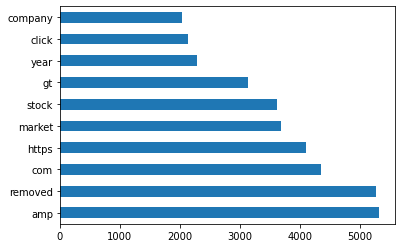

In [37]:
# convert training data to dataframe
X_train_df = pd.DataFrame(X_train.todense(), 
                          columns=cvec.get_feature_names()) # cvec is the CountVectorizer object

# plot top occuring words
X_train_df.sum().sort_values(ascending=False).head(10).plot(kind='barh'); # head(10) gives top ten words

## Baseline Accuracy

In [38]:
y_test.value_counts(normalize=True)

0    0.516236
1    0.483764
Name: subreddit, dtype: float64

# Reinstantiate Train and Test Data

To avoid error of instantiating/fitting count vectorizer down below [IMPORTANT]

In [39]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y, # stratify means the proportion of 0s and 1s are kept
                                                    random_state=42)

# Logistic Regression with Count Vectorizer

In [40]:
pipe = Pipeline([('cvec', CountVectorizer()),
                 ('lr', LogisticRegression(solver='lbfgs'))
                ])

In [41]:
cross_val_score(pipe, X_train, y_train, cv=5)


c:\Users\redoc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\redoc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

array([0.80491329, 0.80154143, 0.78746988, 0.78987952, 0.79373494])

In [42]:
# ii. Fit into model
pipe.fit(X_train, y_train)

# Training score
print(pipe.score(X_train, y_train))

# Test score
print(pipe.score(X_test, y_test))

c:\Users\redoc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9649224245928496
0.8014475743348983


### GridSearch

In [43]:
pipe_params = {
    'cvec__max_features': [2500, 3000, 3500],
    'cvec__min_df': [0.05], # change to percentage
    'cvec__max_df': [0.9],
    'cvec__ngram_range': [(1,2)],
    "lr__C": [10,2,1.25] # np.logspace() # 1,1.25,num=5
}
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}
#scorers dictionary allows us to prioritize which score we want for the model. Then we refit back the parameters to our model
gs_count_logreg = GridSearchCV(pipe,param_grid=pipe_params,scoring=scorers,refit='accuracy_score', cv=5)

# https://stackoverflow.com/questions/24005762/understanding-the-ngram-range-argument-in-a-countvectorizer-in-sklearn 
# https://stackoverflow.com/questions/27697766/understanding-min-df-and-max-df-in-scikit-countvectorizer

This gridsearch took 11 min 6.3 sec

In [44]:
gs_count_logreg.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid={'cvec__max_df': [0.9],
                         'cvec__max_features': [2500, 3000, 3500],
                         'cvec__min_df': [0.05], 'cvec__ngram_range': [(1, 2)],
                         'lr__C': [10, 2, 1.25]},
             refit='accuracy_score',
             scoring={'accuracy_score': make_scorer(accuracy_score),
                      'precision_score': make_scorer(precision_score),
                      'recall_score': make_scorer(recall_score)})

In [45]:
print(gs_count_logreg.best_score_)
gs_count_logreg.best_params_

0.7308475984864312


{'cvec__max_df': 0.9,
 'cvec__max_features': 2500,
 'cvec__min_df': 0.05,
 'cvec__ngram_range': (1, 2),
 'lr__C': 2}

In [46]:
gs_count_logreg.score(X_train, y_train)


0.7322925701069674

In [47]:
gs_count_logreg.score(X_test, y_test)


0.7298513302034428

Try Again but with different C values for Logistic Regression

In [48]:
for i in np.logspace(0.096,1,num=10):
    print(1/i)

0.8016780633876791
0.6361441760824124
0.504790428034794
0.4005591590962541
0.31785000472481023
0.25221898740626414
0.20013974095522713
0.15881403823537268
0.12602144191976725
0.1


In [49]:
pipe_params = {
    'cvec__max_features': [2500, 3000, 3500],
    'cvec__min_df': [0.05],
    'cvec__max_df': [.8,.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)],
    "lr__C": np.logspace(0.096,1,num=10) # np.logspace()
}
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}
#scorers dictionary allows us to prioritize which score we want for the model. Then we refit back the parameters to our model
gs_count_logreg2 = GridSearchCV(pipe,param_grid=pipe_params,scoring=scorers,refit='accuracy_score', cv=5)

This gridsearch took  34 min  42.2 sec

In [50]:
gs_count_logreg2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid={'cvec__max_df': [0.8, 0.9, 0.95],
                         'cvec__max_features': [2500, 3000, 3500],
                         'cvec__min_df': [0.05],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'lr__C': array([ 1.24738351,  1.57197069,  1.98102013,  2.49651013,  3.14613807,
        3.96480856,  4.99650892,  6.29667258,  7.93515758, 10.        ])},
             refit='accuracy_score',
             scoring={'accuracy_score': make_scorer(accuracy_score),
                      'precision_score': make_scorer(precision_score),
                      'recall_score': make_scorer(recall_score)})

In [51]:
print(gs_count_logreg2.best_score_)
gs_count_logreg2.best_params_

0.7308475984864312


{'cvec__max_df': 0.8,
 'cvec__max_features': 2500,
 'cvec__min_df': 0.05,
 'cvec__ngram_range': (1, 2),
 'lr__C': 1.247383514242943}

In [52]:
gs_count_logreg2.score(X_train, y_train)


0.7321962031415631

In [53]:
gs_count_logreg2.score(X_test, y_test)


0.7298513302034428

---

In [105]:
pipe_params = {
    'cvec__max_features': [2500, 3000, 3500],
    'cvec__min_df': [1, 2],
    'cvec__max_df': [.8,.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)],
    "lr__C": np.logspace(1,1.25,num=5) # np.logspace()
}
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}
#scorers dictionary allows us to prioritize which score we want for the model. Then we refit back the parameters to our model
gs_count_logreg3 = GridSearchCV(pipe,param_grid=pipe_params,scoring=scorers,refit='accuracy_score', cv=5)

This gridsearch took  16  min   25.4 sec

In [106]:
gs_count_logreg3.fit(X_train, y_train)

c:\Users\redoc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\redoc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid={'cvec__max_df': [0.8, 0.9, 0.95],
                         'cvec__max_features': [2500, 3000, 3500],
                         'cvec__min_df': [1, 2],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'lr__C': array([10.        , 11.54781985, 13.33521432, 15.39926526, 17.7827941 ])},
             refit='accuracy_score',
             scoring={'accuracy_score': make_scorer(accuracy_score),
                      'precision_score': make_scorer(precision_score),
                      'recall_score': make_scorer(recall_score)})

In [107]:
print(gs_count_logreg3.best_score_)
gs_count_logreg3.best_params_

0.7759466536666898


{'cvec__max_df': 0.8,
 'cvec__max_features': 3500,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1),
 'lr__C': 10.0}

In [108]:
gs_count_logreg3.score(X_train, y_train)


0.9218463910571456

In [109]:
gs_count_logreg3.score(X_test, y_test)


0.7785602503912363

---

### Accuracy Check

#### Pipeline Accuracy

In [ ]:
# Get predictions
preds = pipe.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

In [ ]:
# View confusion matrix

plot_confusion_matrix(gs_count_logreg, X_test, y_test, cmap='Blues', values_format='d');

In [ ]:
# Calculate the specificity

spec = tn / (tn + fp)

print('Specificity:', spec)

In [ ]:
# Calculate the sensitivity

sens = tp/(tp+fn)

print('Sensitivity:', sens)

In [ ]:
accuracy = (tp+tn)/(tp+fp+tn+fn)

print('Accuracy:', accuracy)

---

#### Gridsearch Accuracy

In [ ]:
# Get predictions
preds = gs_count_logreg.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

In [ ]:
# View confusion matrix

plot_confusion_matrix(gs_count_logreg, X_test, y_test, cmap='Blues', values_format='d');

In [ ]:
# Calculate the specificity

spec = tn / (tn + fp)

print('Specificity:', spec)

In [ ]:
# Calculate the sensitivity

sens = tp/(tp+fn)

print('Sensitivity:', sens)

In [ ]:
accuracy = (tp+tn)/(tp+fp+tn+fn)

print('Accuracy:', accuracy)

# Logistic Regression with TIFD Vectorizer

In [ ]:
pipe_tfid_logreg = Pipeline([('tfid', TfidfVectorizer()),
                 ('lr', LogisticRegression(solver='lbfgs'))
                ])

In [ ]:
cross_val_score(pipe_tfid_logreg, X_train, y_train, cv=5)


In [ ]:
# ii. Fit into model
pipe_tfid_logreg.fit(X_train, y_train)

# Training score
print(pipe_tfid_logreg.score(X_train, y_train))

# Test score
print(pipe_tfid_logreg.score(X_test, y_test))

### Gridsearch

In [ ]:
pipe2_params = {
    'tfid__max_features': [2500, 3000, 3500],
    'tfid__min_df': [1, 2],
    'tfid__max_df': [.8,.9, .95],
    'tfid__ngram_range': [(1,1), (1,2)]
}


gs_tfid_logreg = GridSearchCV(pipe_tfid_logreg,param_grid=pipe2_params,scoring=scorers,refit='accuracy_score', cv=5)

In [ ]:
gs_tfid_logreg.fit(X_train, y_train)
print(gs_tfid_logreg.best_score_)
gs_tfid_logreg.best_params_

In [ ]:
gs_tfid_logreg.score(X_train, y_train)

In [ ]:
gs_tfid_logreg.score(X_test, y_test)

# Naive Bayes with Count Vectorizer

In [ ]:
# Let's set a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. Multinomial Naive Bayes (estimator)

pipe3 = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [ ]:
cross_val_score(pipe3, X_train, y_train, cv=5)

In [ ]:
# ii. Fit into model
pipe3.fit(X_train, y_train)

# Training score
print(pipe3.score(X_train, y_train))

# Test score
print(pipe3.score(X_test, y_test))

### Gridsearch

In [ ]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_params = {
    'cvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)]
}
# these are for the Grid Search to find the optimum combination of hyperparameters

In [ ]:
# Instantiate GridSearchCV.

gs = GridSearchCV(pipe3, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

In [ ]:
# Fit GridSearch to training data.
gs.fit(X_train, y_train)

In [ ]:
# What's the best score?
print(gs.best_score_)

In [ ]:
# Score model on training set.
gs.score(X_train, y_train)

In [ ]:
# Score model on testing set.
gs.score(X_test, y_test)

# Naive Bayes with TIFD Vectorizer

In [ ]:
# Set up a pipeline with tf-idf vectorizer and multinomial naive bayes

pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [ ]:
cross_val_score(pipe_tvec, X_train, y_train, cv=5)

In [ ]:
# ii. Fit into model
pipe_tvec.fit(X_train, y_train)

# Training score
print(pipe_tvec.score(X_train, y_train))

# Test score
print(pipe_tvec.score(X_test, y_test))

### Gridsearch

In [ ]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# No stop words and english stop words
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_tvec_params = {
    'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1,1), (1,2)]
}

In [ ]:
# Instantiate GridSearchCV.

gs_tvec = GridSearchCV(pipe_tvec, # what object are we optimizing?
                        param_grid = pipe_tvec_params, # what parameters values are we searching?
                        cv=5) # 5-fold cross-validation.

In [ ]:
# Fit GridSearch to training data.
gs_tvec.fit(X_train, y_train)

In [ ]:
print(gs_tvec.best_score_)

In [ ]:
# Score model on training set.
gs_tvec.score(X_train, y_train)

In [ ]:
# Score model on testing set.
gs_tvec.score(X_test, y_test)

# Random Forest

In [55]:
rf = RandomForestClassifier(n_estimators=100)

In [56]:
et = ExtraTreesClassifier(n_estimators=100)

In [58]:
X_train

9369     juicygiuseppe tips newbie think good mix conso...
13856      bradpants inflation reduction act bumps removed
7569     token reddit handle help understanding stock s...
8760     vast cricket microsoft beat earnings quarter c...
810                   nickgg need financial advise removed
                               ...                        
8020         damicorzzz stock apps recommendations removed
10184                              lariumai larium removed
5856       hippofire dca windfall advice requested removed
1019     simdiya stard investing money guys recommend r...
7145     pfftkhaganate amount money need invest gets ea...
Name: Posts, Length: 10377, dtype: object

In [60]:
X_train_df

,aa,aaa,aaaanubha,aaac,aaand,aaatttvvv,aab,aabb,aabeb,aac,...,zylvctx,zymergen,zyou,zyyw,zz,zzaaiiggaa,zzane,zzobk,zzppzw,zzzzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10372,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10373,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10374,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10375,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Model Evaluation
---

Which one has a higher `cross_val_score`?

In [59]:
y_train

9369     1
13856    1
7569     0
8760     1
810      0
        ..
8020     1
10184    1
5856     0
1019     0
7145     0
Name: subreddit, Length: 10377, dtype: int64

In [61]:
cross_val_score(rf, X_train_df, y_train, cv=5).mean()

0.8097711539800821

rf took 14 minutes

In [62]:
cross_val_score(et, X_train_df, y_train, cv=5).mean()

0.8130477981289319

et took 43 minutes

In [63]:
rf_params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 1, 2, 3, 4, 5], # max_depth is the longest path
}
gs = GridSearchCV(rf, param_grid=rf_params, cv=5)
gs.fit(X_train_df, y_train)
print(gs.best_score_)
gs.best_params_

0.8116014578545394


{'max_depth': None, 'n_estimators': 100}

the gridsearch took 70 mins

In [65]:
gs.score(X_train_df, y_train)

0.994410716006553

Reinstantiate training sets

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y, # stratify means the proportion of 0s and 1s are kept
                                                    random_state=42)

In [73]:
# Transform test
X_test = cvec.transform(X_test) # we fit the CountVectorizer data based on the X_Train and use that model to transform T_Test

c:\Users\redoc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


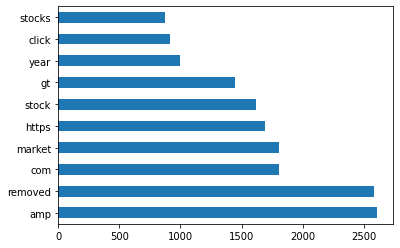

In [74]:
# convert testing data to dataframe
X_test_df = pd.DataFrame(X_test.todense(), 
                          columns=cvec.get_feature_names()) # cvec is the CountVectorizer object

# plot top occuring words
X_test_df.sum().sort_values(ascending=False).head(10).plot(kind='barh'); # head(10) gives top ten words

In [75]:
gs.score(X_test, y_test)

c:\Users\redoc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0.8067292644757433

## Error Analysis [Type 1 and Type 2 Errors]

https://www.datasciencecentral.com/understanding-type-i-and-type-ii-errors/


## ROCAUC